---
title: "GPU Puzzles with Triton"
author: "Nok"
date: "2025-04-12"
categories: [triton, gpu]
---

This post implemented the solutions for [GPU Puzzles](https://github.com/srush/GPU-Puzzles) (which used `numba`) with [Triton](https://triton-lang.org/main/index.html).

Why Triton but not CUDA? A simple reason is that I only have a Macbook. To learn GPU programming,
it's usually best to have a GPU that support CUDA. With `triton`, you can still implement kernel and check for correctness with just CPU. `triton` is a higher level "Block-based" programming than CUDA.



::: {.callout-note}
`triton` only support Linux build officially. If you are working on Mac like me, you can only run it with `TRITON_INTREPRETER=1` for educational purpose.

Build this locally with these steps:  
1. `git clone https://github.com/triton-lang/triton.git`  
2. `pip install -e .` (For some reason it failed with `uv` so I need to use `pip`)
:::

You can find the original [GPU Puzzles](https://github.com/srush/GPU-Puzzles/blob/main/GPU_puzzlers.ipynb) which used Numba's CUDA. For each question I will post both `numba` and `triton` solutions when possible

# Installation
`pip install gpu-python` 

The library packages the utils code used in various tutorials to keep them in one place. I did not write most of these code so credits to the original author.

## Puzzle 1: Map

Implement a "kernel" (GPU function) that adds 10 to each position of vector a and stores it in vector out.

In [1]:
%env TRITON_INTERPRET=1
# %load_ext autoreload
# %autoreload 2

env: TRITON_INTERPRET=1


In [3]:
import numpy as np
import triton
import torch
import triton.language as tl
from gpu_python.gpu_puzzles_utils import CudaProblem, Coord
from gpu_python.triton_utils import check_tensors_gpu_ready, cdiv, print_if
from gpu_python.gpu_puzzles_utils import *

### Numba Solution

# Map

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 |



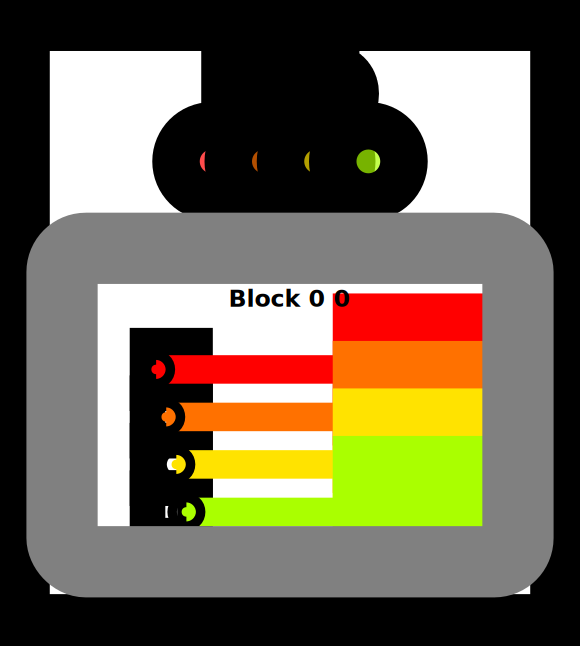

In [ ]:
def map_spec(a):
    return a + 10


def map_test(cuda):
    print(cuda)

    def call(out, a) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 1 lines)
        out[local_i] = a[local_i] + 10

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Map", map_test, [a], out, threadsperblock=Coord(SIZE, 1), spec=map_spec
)
problem.show()

In [ ]:
expected_ans = [10, 11, 12, 13]  # Copy from notebook

In [ ]:
# # This is a normal python function, which launches the triton kernels
def map_add_10(x, bs, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)
    n = x.numel()
    n_blocks = cdiv(n, bs)
    grid = (
        n_blocks,
    )  # how many blocks do we have? can be 1d/2d/3d-tuple or function returning 1d/2d/3d-tuple

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    kernel_fn[grid](x, z, n, bs)

    return z


@triton.jit
def map_add_10_kernel(x_ptr, out_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = pid * bs + tl.arange(0, bs)
    # mask = offs < n
    x = tl.load(x_ptr + offs)
    x = x + 10
    tl.store(out_ptr + offs, x)
    # print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')

In [ ]:
x = torch.tensor([1, 2, 3, 4, 5, 6])
bs = 32

In [8]:
out = map_add_10(x, 32, map_add_10_kernel)
out

tensor([11, 12, 13, 14, 15, 16])

## Puzzle 2 - Zip (Add)

# Zip

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 |



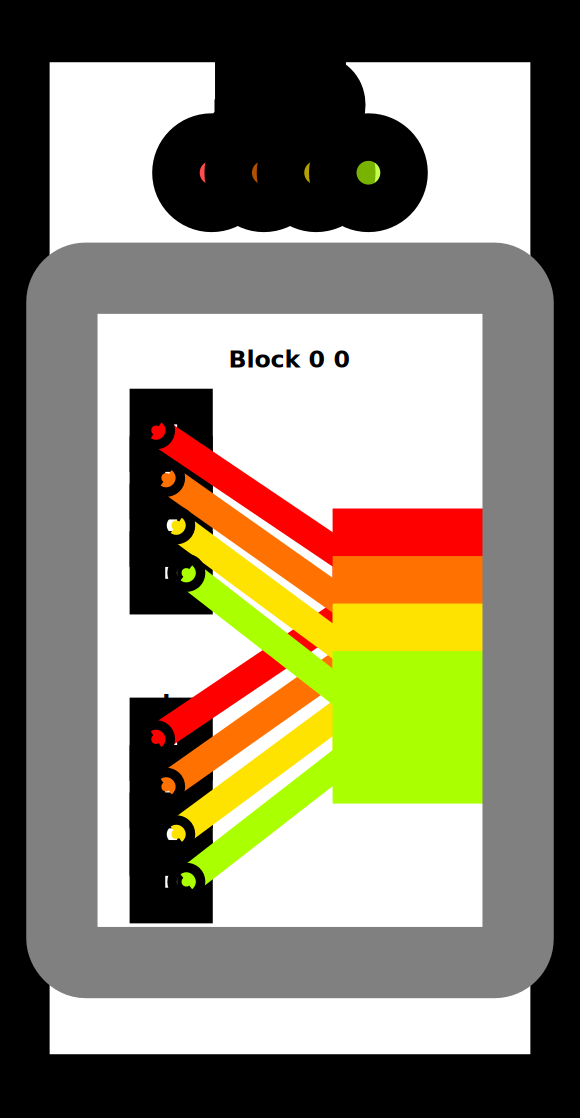

In [ ]:
def zip_spec(a, b):
    return a + b


def zip_test(cuda):
    def call(out, a, b) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 1 lines)
        out[local_i] = a[local_i] + b[local_i]

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Zip", zip_test, [a, b], out, threadsperblock=Coord(SIZE, 1), spec=zip_spec
)
problem.show()

### Triton
In triton this is implemented as vectorized addition.

In [ ]:
@triton.jit
def map_add_kernel(x_ptr, y_ptr, out_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = pid * bs + tl.arange(0, bs)
    # mask = offs < n
    x = tl.load(x_ptr + offs)
    y = tl.load(y_ptr + offs)
    out = x + y
    tl.store(out_ptr + offs, out)
    # print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')


# # This is a normal python function, which launches the triton kernels
def map_add(x, y, bs, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)
    n = x.numel()
    n_blocks = cdiv(n, bs)
    grid = (
        n_blocks,
    )  # how many blocks do we have? can be 1d/2d/3d-tuple or function returning 1d/2d/3d-tuple

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    kernel_fn[grid](x, y, z, n, bs)

    return z

In [ ]:
x = torch.tensor([1, 2, 3, 4, 5, 6])
y = torch.tensor([7, 8, 9, 10, 11, 12])
bs = 32

map_add(x, y, bs, map_add_kernel)

tensor([ 8, 10, 12, 14, 16, 18])

##  Puzzle 3 - Guard Clause
You have more threads than positions, so you need to make sure the operations only executed when there are actual value inside it.

# Guard

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             0 |             0 |             0 |             0 |



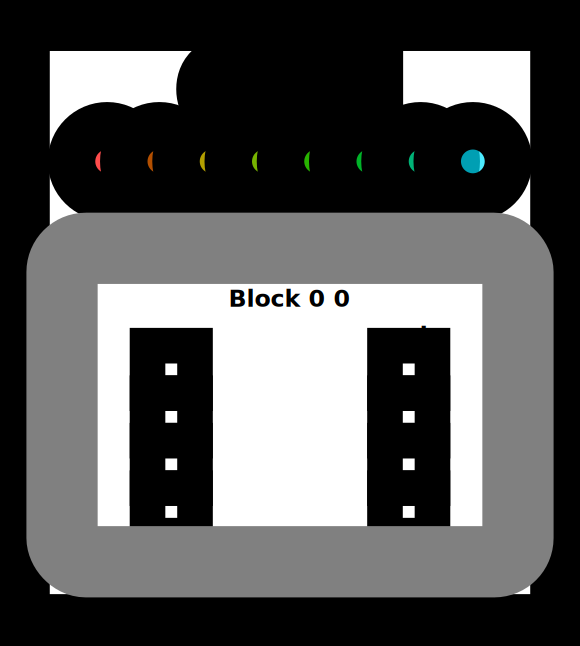

In [4]:
def map_guard_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        # FILL ME IN (roughly 2 lines)
        if local_i >= size:
            return

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
problem = CudaProblem(
    "Guard",
    map_guard_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(8, 1),
    spec=map_spec,
)
problem.show()

### Triton
In Triton you use a vector of mask instead of a guard clause (in CUDA the unit is a scalar)

In [ ]:
@triton.jit
def map_add_kernel_with_guard(x_ptr, y_ptr, out_ptr, n, bs: tl.constexpr):
    pid = tl.program_id(0)
    offs = pid * bs + tl.arange(0, bs)
    mask = offs < n
    x = tl.load(x_ptr + offs, mask=mask)
    y = tl.load(y_ptr + offs, mask=mask)
    out = x + y
    tl.store(out_ptr + offs, out)
    # print_if(f'pid = {pid} | offs = {offs}, mask = {mask}, x = {x}', '')


# # This is a normal python function, which launches the triton kernels
def map_add(x, y, bs, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)
    n = x.numel()
    n_blocks = cdiv(n, bs)
    grid = (
        n_blocks,
    )  # how many blocks do we have? can be 1d/2d/3d-tuple or function returning 1d/2d/3d-tuple

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    kernel_fn[grid](x, y, z, n, bs)

    return z

In [ ]:
x = torch.tensor([1, 2, 3, 4, 5, 6])
y = torch.tensor([7, 8, 9, 10, 11, 12])
bs = 32

map_add(x, y, bs, map_add_kernel_with_guard)

['constexpr[32]'] [6]


tensor([ 8, 10, 12, 14, 16, 18])

## Puzzle 4 - Map 2D

> Implement a kernel that adds 10 to each position of a and stores it in out. Input a is 2D and square. You have more threads than positions.

# Map 2D

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             1 |             1 |             0 |             0 |



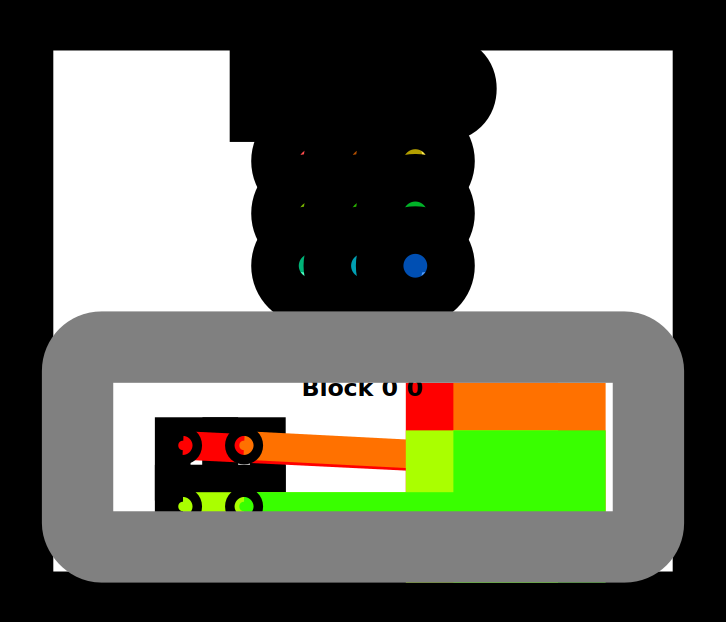

In [ ]:
def map_2D_test(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, local_j] + 10

    return call


# My comment: alternative solution is to exit early, requires less indentation
def map_2D_test_alternative(cuda):
    def call(out, a, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y

        if local_i >= size or local_j >= size:
            return

        out[local_i, local_j] = a[local_i, local_j] + 10

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
problem = CudaProblem(
    "Map 2D",
    map_2D_test,
    [a],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=map_spec,
)
problem.show()

In [ ]:
# # This is a normal python function, which launches the triton kernels
def map_2d(x, bs0, bs1, kernel_fn):
    z = torch.zeros_like(x)
    check_tensors_gpu_ready(x, z)

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function
    h, w = x.shape
    grid = (cdiv(h, bs0), cdiv(w, bs1))
    kernel_fn[grid](x, z, h, w, bs0, bs1)

    return z


@triton.jit
def map_2d_kernel(x_ptr, out_ptr, h, w, bs0: tl.constexpr, bs1: tl.constexpr):
    pid0 = tl.program_id(0)
    pid1 = tl.program_id(1)
    offs_0 = pid0 * bs0 + tl.arange(0, bs0)
    offs_1 = pid1 * bs1 + tl.arange(0, bs1)
    offs = (
        w * offs_0[:, None] + offs_1[None, :]
    )  # 2d matrix! - we multiply first offset by width, see image above

    mask_0 = offs_0 < h  # 1d vector
    mask_1 = offs_1 < w  # 1d vector
    mask = (
        mask_0[:, None] & mask_1[None, :]
    )  # 2d matrix! - data musn't go out of bounds along either axis, therefore `logical and` of the individual masks

    print(
        f"pid: [{pid0}, {pid1}] | {mask=} | {offs=}"
    )  # To check we don't launch more kernel than we need.
    x = tl.load(x_ptr + offs, mask=mask)
    x = x + 10
    tl.store(out_ptr + offs, x)

In [ ]:
x = torch.rand((10, 10))  # 2D tensor
bs = 4

map_2d(x, bs, bs, map_2d_kernel)

pid: [[0], [0]] | mask=array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]]) | offs=array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33]], dtype=int32)
pid: [[0], [1]] | mask=array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]]) | offs=array([[ 4,  5,  6,  7],
       [14, 15, 16, 17],
       [24, 25, 26, 27],
       [34, 35, 36, 37]], dtype=int32)
pid: [[0], [2]] | mask=array([[ True,  True, False, False],
       [ True,  True, False, False],
       [ True,  True, False, False],
       [ True,  True, False, False]]) | offs=array([[ 8,  9, 10, 11],
       [18, 19, 20, 21],
       [28, 29, 30, 31],
       [38, 39, 40, 41]], dtype=int32)
pid: [[1], [0]] | mask=array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  T

tensor([[10.2780, 10.4237, 10.2073, 10.2037, 10.9769, 10.5735, 10.3639, 10.0373,
         10.4634, 10.4335],
        [10.0000, 10.0000, 10.1232, 10.8838, 10.2060, 10.2776, 10.0662, 10.2528,
         10.7417, 10.9742],
        [10.0000, 10.0000, 10.6354, 10.4080, 10.3655, 10.3983, 10.1110, 10.7007,
         10.7801, 10.8673],
        [10.0000, 10.0000, 10.1035, 10.4442, 10.4608, 10.5741, 10.2253, 10.0920,
         10.3829, 10.2764],
        [10.5986, 10.6847, 10.1790, 10.5229, 10.7628, 10.5600, 10.3200, 10.7449,
         10.5641, 10.3012],
        [10.0000, 10.0000, 10.2096, 10.8919, 10.2964, 10.5348, 10.4757, 10.2180,
         10.4784, 10.3402],
        [10.0000, 10.0000, 10.4078, 10.4787, 10.2846, 10.3357, 10.4666, 10.1827,
         10.4218, 10.5108],
        [10.0000, 10.0000, 10.6910, 10.2991, 10.6611, 10.5933, 10.1666, 10.4724,
         10.1348, 10.3822],
        [10.3612, 10.7105, 10.4287, 10.2983, 10.1421, 10.2604, 10.8663, 10.1462,
         10.1435, 10.0447],
        [10.0000, 1

## Puzzle 5 - Broadcast

> Implement a kernel that adds `a` and `b` and stores it in out. Inputs `a` and `b` are vectors. You have more threads than positions.

# Zip

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 |

# Broadcast

   Score (Max Per Thread):
   |  Global Reads | Global Writes |  Shared Reads | Shared Writes |
   |             2 |             1 |             0 |             0 |



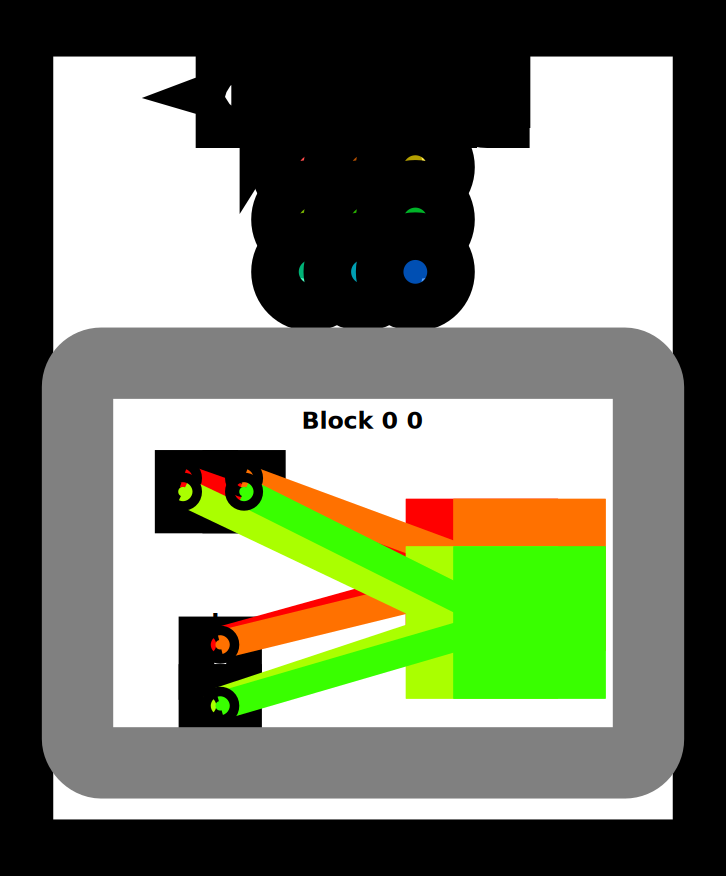

In [ ]:
def zip_spec(a, b):
    return a + b


def zip_test(cuda):
    def call(out, a, b) -> None:
        local_i = cuda.threadIdx.x
        out[local_i] = a[local_i] + b[local_i]

    return call


SIZE = 4
out = np.zeros((SIZE,))
a = np.arange(SIZE)
b = np.arange(SIZE)
problem = CudaProblem(
    "Zip", zip_test, [a, b], out, threadsperblock=Coord(SIZE, 1), spec=zip_spec
)
problem.show()


def broadcast_test(cuda):
    def call(out, a, b, size) -> None:
        local_i = cuda.threadIdx.x
        local_j = cuda.threadIdx.y
        if local_i < size and local_j < size:
            out[local_i, local_j] = a[local_i, 0] + b[0, local_j]

    return call


SIZE = 2
out = np.zeros((SIZE, SIZE))
a = np.arange(SIZE).reshape(SIZE, 1)
b = np.arange(SIZE).reshape(1, SIZE)
problem = CudaProblem(
    "Broadcast",
    broadcast_test,
    [a, b],
    out,
    [SIZE],
    threadsperblock=Coord(3, 3),
    spec=zip_spec,
)
problem.show()

### Triton

Triton are vector base and it comes with a handy `tl.broadcast` function.

In [ ]:
# # This is a normal python function, which launches the triton kernels
def map_broadcast(x, y, bs0, bs1, kernel_fn):
    M, N = x.size(0), y.size(0)

    z = torch.empty(M, N)
    check_tensors_gpu_ready(x, y, z)

    # launch grid!
    # - kernel_fn is the triton kernel, which we write below
    # - grid is the grid we constructed above
    # - x,z,n,bs are paramters that are passed into each kernel function

    grid = (cdiv(M, bs0), cdiv(N, bs1))
    kernel_fn[grid](x, y, z, M, N, bs0, bs1)

    return z


@triton.jit
def dynamic_add_kernel(
    x_ptr,
    y_ptr,
    out_ptr,
    M,  # Size of first vector
    N,  # Size of second vector
    BLOCK_M: tl.constexpr,
    BLOCK_N: tl.constexpr,
):
    pid_m = tl.program_id(0)
    pid_n = tl.program_id(1)

    # Offsets for 2D output blocks
    offs_m = pid_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = pid_n * BLOCK_N + tl.arange(0, BLOCK_N)

    # Mask to avoid out-of-bounds
    mask_m = offs_m < M
    mask_n = offs_n < N

    # Broadcast 1D inputs to 2D via modulo indexing
    x_idx = offs_m % M  # Replicate x along N dimension
    y_idx = offs_n % N  # Replicate y along M dimension

    x = tl.load(x_ptr + x_idx, mask=mask_m)
    y = tl.load(y_ptr + y_idx, mask=mask_n)

    ## Implementation I - Using Block Pointer since the output is a tensor due to broadcasting
    # Expand and compute
    x_2d = tl.broadcast_to(x[:, None], (BLOCK_M, BLOCK_N))
    y_2d = tl.broadcast_to(y[None, :], (BLOCK_M, BLOCK_N))
    output = x_2d + y_2d

    # Store result
    out_block_ptr = tl.make_block_ptr(
        out_ptr,
        shape=(M, N),
        strides=(N, 1),
        offsets=(pid_m * BLOCK_M, pid_n * BLOCK_N),
        block_shape=(BLOCK_M, BLOCK_N),
        order=(1, 0),
    )
    tl.store(out_block_ptr, output)


SIZE = 10
x = torch.arange(1, SIZE)
y = torch.ones(7)
bs = 4

# Two 1D vector with (10,1) and (3,1) result in a (10,3) 2D Matrix with broadcasting
map_broadcast(x, y, bs, bs, dynamic_add_kernel)

tensor([[ 2.,  2.,  2.,  2.,  2.,  2.,  2.],
        [ 1.,  3.,  3.,  3.,  3.,  3.,  3.],
        [ 2.,  4.,  4.,  4.,  4.,  4.,  4.],
        [ 3.,  5.,  5.,  5.,  5.,  5.,  5.],
        [ 6.,  6.,  6.,  6.,  6.,  6.,  6.],
        [ 5.,  7.,  7.,  7.,  7.,  7.,  7.],
        [ 6.,  8.,  8.,  8.,  8.,  8.,  8.],
        [ 7.,  9.,  9.,  9.,  9.,  9.,  9.],
        [10., 10., 10., 10., 10., 10., 10.]])